In [2]:
import pandas as pd

file_location = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'

car_sales_dataset=pd.read_csv(file_location)

car_sales_dataset.head()

,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


In [3]:
car_sales_dataset['Month']=pd.to_datetime(car_sales_dataset['Month'],infer_datetime_format=True)

car_sales_dataset_indexed=car_sales_dataset.set_index(['Month'])

car_sales_dataset_indexed=car_sales_dataset_indexed['Sales']

car_sales_dataset_indexed.head()


Month
1960-01-01     6550
1960-02-01     8728
1960-03-01    12026
1960-04-01    14395
1960-05-01    14587
Name: Sales, dtype: int64

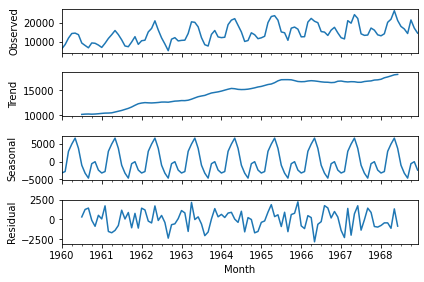

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(car_sales_dataset_indexed,model="additive")
decompose_data.plot();

In [5]:
def test_stationarity(timeseries):
  import matplotlib.pyplot as plt 

  timeseries.dropna(inplace=True)

  rolmean = timeseries.rolling(window=12).mean()
  rolstd = timeseries.rolling(window=12).std()

  orig = plt.plot(timeseries, label='Original')
  mean = plt.plot(rolmean, label='Rolling mean')
  std = plt.plot(rolstd, label='Rolling std')

  plt.legend(loc='best')
  plt.title('Timeseries data with rolling mean and std.dev.')
  plt.show()

  from statsmodels.tsa.stattools import adfuller

  dftest = adfuller(timeseries)
  dfoutput = pd.Series(dftest[0:4], index = ['The test statistic',"Mackinnon's approximate p-value","#usedLags","NOBS"])

  print(dfoutput)

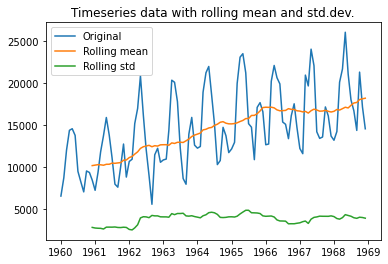

The test statistic                 -1.223813
Mackinnon's approximate p-value     0.663269
#usedLags                          12.000000
NOBS                               95.000000
dtype: float64


In [6]:
test_stationarity(car_sales_dataset_indexed)

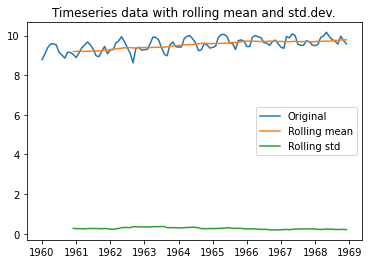

The test statistic                 -1.452425
Mackinnon's approximate p-value     0.556901
#usedLags                          13.000000
NOBS                               94.000000
dtype: float64


In [7]:
import numpy as np

car_sales_dataset_indexed_log_scaled = np.log(car_sales_dataset_indexed)

test_stationarity(car_sales_dataset_indexed_log_scaled)

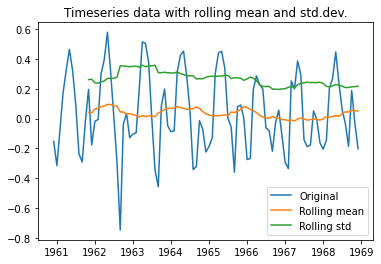

The test statistic                 -2.023542
Mackinnon's approximate p-value     0.276347
#usedLags                          12.000000
NOBS                               84.000000
dtype: float64


In [8]:
ma = car_sales_dataset_indexed_log_scaled.rolling(window=12).mean()

car_sales_dataset_indexed_log_scaled_minus_ma = car_sales_dataset_indexed_log_scaled - ma

test_stationarity(car_sales_dataset_indexed_log_scaled_minus_ma)

In [9]:
# pip install fbprophet

In [10]:
from fbprophet import Prophet
from sklearn.model_selection import train_test_split

model_prophet = Prophet()

# prepare expected column names
car_sales_dataset.columns = ['ds','y']

train, test = train_test_split(car_sales_dataset, test_size = 0.10, shuffle=False)

# car_sales_dataset.head()

model_prophet_fit = model_prophet.fit(train)

# 1968-02-01
# 1968-12-01
# test data is for 10 months

future = model_prophet.make_future_dataframe(periods=11, freq='M')
predictions = model_prophet.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


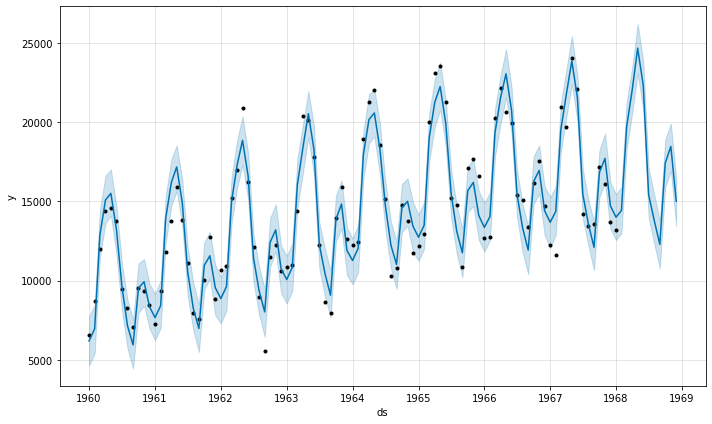

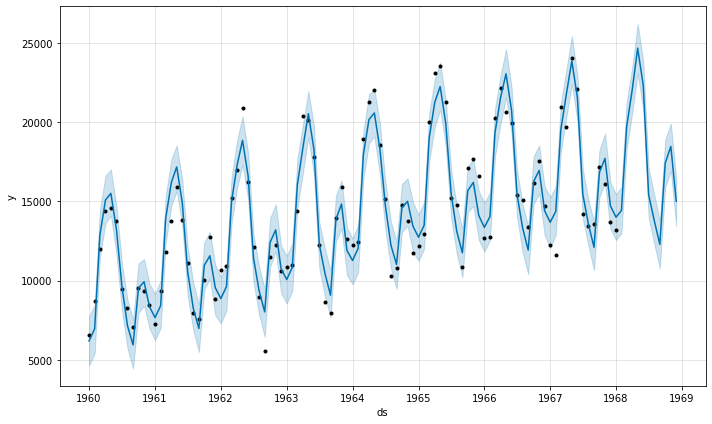

In [11]:
model_prophet.plot(predictions)

In [13]:
predictions.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
103,1968-07-31,17553.392051,12320.258580,15427.741216,17531.883689,17575.396867,-3755.778420,-3755.778420,-3755.778420,-3755.778420,-3755.778420,-3755.778420,0.0,0.0,0.0,13797.613632
104,1968-08-31,17586.636869,10780.687718,13806.723878,17557.739718,17613.625919,-5291.225606,-5291.225606,-5291.225606,-5291.225606,-5291.225606,-5291.225606,0.0,0.0,0.0,12295.411264
105,1968-09-30,17618.809274,15913.883009,18915.123826,17582.807987,17651.218648,-196.712224,-196.712224,-196.712224,-196.712224,-196.712224,-196.712224,0.0,0.0,0.0,17422.097050
106,1968-10-31,17652.054092,16925.196581,19908.926460,17609.483101,17690.045156,820.744687,820.744687,820.744687,820.744687,820.744687,820.744687,0.0,0.0,0.0,18472.798778
107,1968-11-30,17684.226496,13413.304272,16440.618387,17635.492439,17729.611868,-2666.832592,-2666.832592,-2666.832592,-2666.832592,-2666.832592,-2666.832592,0.0,0.0,0.0,15017.393905


MAE: 1534.285


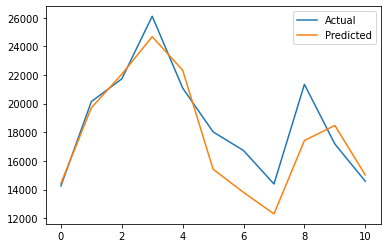

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
# calculate MAE between expected and predicted values for december
y_true = test['y'].values
y_pred = predictions['yhat'][-11:].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [18]:
test.tail()

,ds,y
103,1968-08-01,16722
104,1968-09-01,14385
105,1968-10-01,21342
106,1968-11-01,17180
107,1968-12-01,14577
